# DSM150 - Neural Networks Coursework 2

## Introduction

Introduced to the major public ChatGPT quickly demonstrated the enormous potential of Large Language Models(LLMs). This marked the beginning of a new era where the concepts of neural networks left academic circles, becoming a topic of conversations of everyday life. Subsequently, these LLMs introduced the capability of image recognition. Users are able to upload images and let them be analyzed and described by LLMs, which further underlined the versatility and potential of neural networks. Today, Convolutional Neural Networks have found extensive application across various fields. From medical imaging, such as fraction detection in x-ray images, to the 'simple' object detection on smartphones. The impact of CNNs is both profound and pervasive. This coursework report seeks to explore the practical realization of CNNs, as presented in "Deep Learning with Python", highlighting the indispensable role in the digital age. 


### Classification Task Overview

Following to the introduction, this section aims to define the specific classification task that forms the core focus of the coursework. The objective is to develop an CNN model capable to accurately classify images of animals into five distinct category, each representing a different type of animal. The animals for the classification tasks are as follows:
- Category 1: Cat
- Category 2: Dog
- Category 3: Elephant
- Category 4: Horse
- Category 5: Lion

The task is designed ti challenge the models ability to discem and learn from the unique feature characteristics of each animal type, ranging from texture and shape to size and environmental context. 





## Dataset Description

The dataset that is used for the classification task holds images representing five distinct animal categories ( also see 'Classification Task Overview'). These datset was sourced from Kaggle and can be found under the name 'Animals - Animals Classification Dataset [1]'. It contains 15'000 pictures of animals, which has been collected from Google Images. The Dataset is splitted in training images and validation images. The validation sets holds 300 images for each animal type. This roughly represents the relative size of 11% of the training images.

## Course Work Approach

This course work adopts a structured, iterative approach to explore, implement and refine Convolutional Neural Networks (CNNs) for an image recognitions task. The approach can be subdivided into distinct phases, each designed to build-up on the previous steps.  The process is as follows:

1. Exploring the Images:
- Show Images: A subset of the dataset will be visually examined to understand the variety and characteristics of the data. This step is designed to create an understanding of potential challenges in image recognition tasks, such as image orientation and lighting.
- Count of Images -> Class Distribution: This step is designed to picture the class distribution of target classes. This step is supposed to detect any class imbalances. A balanced dataset is essential to create a robust and unbiased model.

2. Loading and Preparation:
- This phase covers the image loading and preparation for the model training. This tasks covers preprocessing steps like image normalizing and rescaling the data, implementing an image generator and applying data augmentation techniques.

3. Define a Base Model:
- A baseline CNN is created and trained on the dataset prepared on the previous step. The model is supposed to serve as a reference in terms of performance and accuracy to identify areas of improvement.

4. Applying Measures to Improve Model Performance: **ADAPT THIS SECTION**
- Print Standard Parameters: Commonly parameters will be plotted such as trainings and validation accuracy in relation to observe the different training stages of the model. 
- Print Confusion Matrix: The performance of the baseline model will be evaluated by creating a confusion matrix, which gives insights to the models accuracy, recall and precision.

5. Structured Approach to improve Base Model:
- A systematic approach will be employed to  iteratively improve the base model. This involves changes in the architectures.

6. Using a Pretrained Convolutional Network:
- To further discover different techniques, a pretrained CNN will be incorporated. This approach will a allow the model to benefit from features learned on  vast amount of pictures and objects, aiming to improve the generalization capabilities. 

7. Visualizing Structures:
- Finally, the internal structures and features learned by the CNN will be visualized. This step is crucial for understanding how the model interprets and processes image data, providing valuable insights into its decision-making process.

## 1. Exploring the Images:

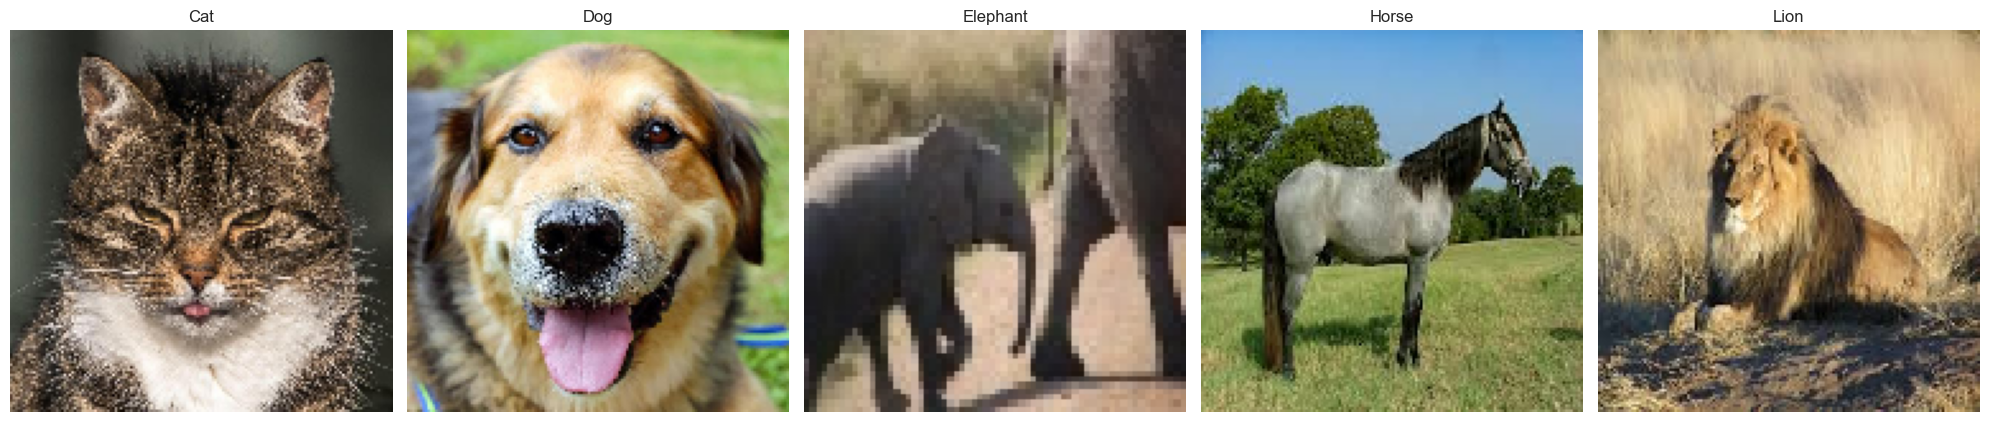

In [119]:
import os, random

import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

dir_base_train= './data/animals/train/'
dir_train_cat= os.path.join(dir_base_train,'cat')
dir_train_dog= os.path.join(dir_base_train,'dog')
dir_train_elephant= os.path.join(dir_base_train,'elephant')
dir_train_horse= os.path.join(dir_base_train,'horse')
dir_train_lion= os.path.join(dir_base_train,'lion')

cat_path_img= os.path.join(dir_train_cat, random.choice(os.listdir(dir_train_cat)))
dog_path_img= os.path.join(dir_train_dog,random.choice(os.listdir(dir_train_dog)))
elephant_path_img= os.path.join(dir_train_elephant,random.choice(os.listdir(dir_train_elephant)))
horse_path_img= os.path.join(dir_train_horse, random.choice(os.listdir(dir_train_horse)))
lion_path_img= os.path.join(dir_train_lion, random.choice(os.listdir(dir_train_lion)))

cat_img = image.img_to_array(image.load_img(cat_path_img, target_size=(150,150)))
dog_img = image.img_to_array(image.load_img(dog_path_img, target_size=(150,150)))
elephant_img = image.img_to_array(image.load_img(elephant_path_img, target_size=(150,150)))
horse_img = image.img_to_array(image.load_img(horse_path_img, target_size=(150,150)))
lion_img = image.img_to_array(image.load_img(lion_path_img, target_size=(150,150)))

# Set up the matplotlib figure and axes, specifying the figure size and the grid layout
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

# List of the images
images = [cat_img, dog_img, elephant_img, horse_img, lion_img]

# Titles for each subplot
titles = ['Cat', 'Dog', 'Elephant', 'Horse', 'Lion']

# Plot each image
for i, ax in enumerate(axes.flat):
    # Display image
    ax.imshow(images[i] / 255.)  # Normalize the image to [0,1] since matplotlib expects floats in [0,1] or integers in [0, 255]
    ax.set_title(titles[i])  # Set a title for each subplot
    ax.axis('off')  # Turn off axis

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()  # Display the figure with the images


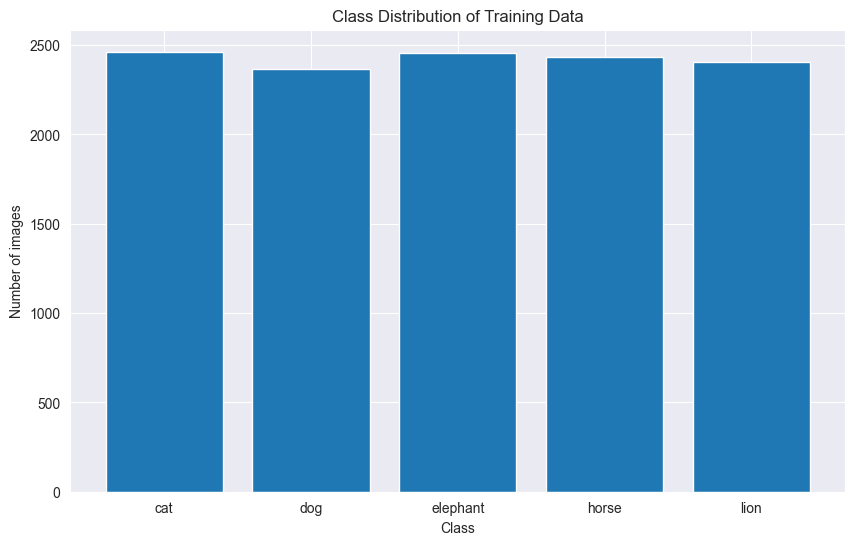

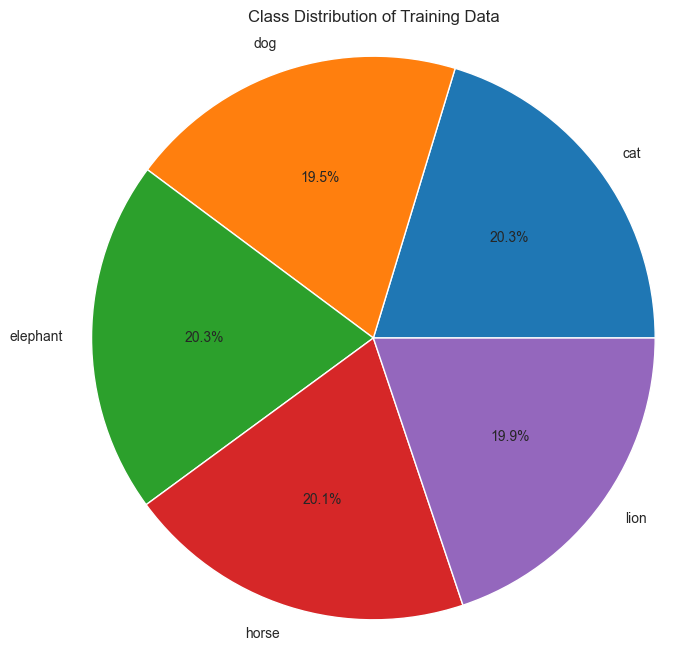

In [120]:
# Class distributions Images
classes = ['cat', 'dog', 'elephant', 'horse', 'lion']
class_counts = {}

for class_name in classes:
    dir_path = os.path.join(dir_base_train, class_name)
    class_counts[class_name] = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])

# Data
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Class Distribution of Training Data')
plt.show()

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=classes, autopct='%1.1f%%')
plt.title('Class Distribution of Training Data')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

On the above charts can be seen, that the data is almost equally distributed. Only minor differences can be stopped between each class. As a result there is not need to take care of under- or overrepresented classes in the process of data preparation. There is no risk of a bias caused by an imbalanced dataset.

# 2. Loading and Preparation

The used dateset was downloaded from Kaggel. The dataset originally consists of a 'train' and 'val' folder. Both folders will be used training the model. To generate an unbiased measure of the models performance a test set will be created an hold back to evaluated the model with unseen data.

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers

In [24]:
# define base directory where pictures stored
dir_base_train= './data/animals/train/'
dir_base_val= './data/animals/val/'
dir_base_test= './data/animals/test/'

In [25]:
import os, shutil
from sklearn.model_selection import train_test_split

animal_classes= ['cat', 'dog', 'elephant','horse', 'lion'] 


# define relative size testset
test_size= 0.1

# define a directory for each class

for class_dir in animal_classes:
    
    dest_dir= os.path.join(dir_base_test, class_dir)
    
    # define the source directory
    src_dir= os.path.join(dir_base_train, class_dir)
    
    # get all the files names from the dir
    fnames= os.listdir(src_dir)
    
    train_files, test_files = train_test_split(fnames, test_size=test_size, random_state= 42)
    
    # define destination dir
    os.makedirs(dest_dir, exist_ok=True)
    
    # move files to test dir
    for fname in test_files:
        shutil.move(os.path.join(dir_base_train, class_dir, fname), os.path.join(dest_dir, fname))

In [4]:
# import lib for Image Generator
#from keras.preprocessing.image import ImageDataGenerator

# rescale images by 1/255
train_datagen= ImageDataGenerator(rescale=1./255)
val_datagen= ImageDataGenerator(rescale=1./255)
test_datagen= ImageDataGenerator(rescale=1./255)

In [5]:

# read img from target dirs, resize image to 150x150, 
train_generator= train_datagen.flow_from_directory(
    dir_base_train,
    target_size=(150,150),
    batch_size=64,
    class_mode='categorical',
    shuffle= True
    
)


Found 10910 images belonging to 5 classes.


In [6]:
val_generator= val_datagen.flow_from_directory(
    dir_base_val,
    target_size=(150,150),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

Found 1497 images belonging to 5 classes.


In [50]:
# define generator fo test data
test_generator= test_datagen.flow_from_directory(
    dir_base_test,
    target_size= (150,150),
    batch_size= 64,
    class_mode= 'categorical',
    shuffle= False
)

Found 1349 images belonging to 5 classes.


In [8]:
for data_batch, labels_batch in train_generator:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break

Data batch shape: (64, 150, 150, 3)
Labels batch shape: (64, 5)


In [9]:
input_shape= (150, 150, 3)

### Helper Functions:

Three helper functions are shown in the following sections. The functions are always used to illustrate the performance of a model. Combining and separating this functionality makes it possible to make the code more modular and clearer. The functions can be summarized as follows:

- plot_acc_loss: These functions plots the training history of the model for accuracy and loss including the accuracy and loss of the validation data.
- plot_roc_auc: Here the ROC-AUC curve is broken down into the individual classes in order to see the classification performance of the model.
- plot_classification_report: This method uses the confusion matrix to print the classification report to get the precision, recall and F1 score values.
- plot_conf_matrix: Using this method, a heatmap is plotted that depicts the confusion matrix for the individual target classes.

In [121]:
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    # Extracts trainings metrics from the training history
    acc = history.history['accuracy']  # Training accuracy for each epoch
    val_acc = history.history['val_accuracy']  # Validation accuracy for each epoch
    loss = history.history['loss']  # Training loss for each epoch
    val_loss = history.history['val_loss']  # Validation loss for each epoch

    # Generates a list of epoch numbers starting from 1 to the number of the final epoch
    epochs = range(1, len(acc) + 1)

    # Plotting the Training Accuracy
    plt.plot(epochs, acc, 'bo', label='Training acc')  # 'bo' for blue dot
    plt.plot(epochs, val_acc, 'b', label='Validation acc')  # 'b' for a solid blue line
    plt.title('Training and validation accuracy')  # Title of the first plot
    plt.legend()  # Displays a legend to label the training and validation accuracy

    plt.figure()  # Creates a new figure for the next plot

    # Plotting the Training Loss
    plt.plot(epochs, loss, 'bo', label='Training loss')  # Again, 'bo' for blue dot
    plt.plot(epochs, val_loss, 'b', label='Validation loss')  # And 'b' for a solid blue line
    plt.title('Training and validation loss')  # Title of the second plot
    plt.legend()  # Displays a legend to label the training and validation loss

    plt.show()  # Displays the plots

The function *plot_acc_loss takes* a history object from a trained model and visualizes its training and validation accuracy, as well as loss over all epochs. It generates two plots: the first shows the accuracy of the model during training and validation, and the second shows the loss during training and validation. This function is useful for evaluating the model's performance over time, checking for overfitting, and making decisions about further training and model adjustments.

In [11]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt  # Import matplotlib for plotting

def plot_roc_auc(model, test_generator):
    # Calculate the number of steps per epoch for the test set
    # Use ceil to ensure that no sample is missed
    test_steps = np.ceil(test_generator.samples / test_generator.batch_size).astype(int)
    
    # Use the model to predict probabilities for each class on the test set
    prediction_probabilities = model.predict(test_generator, steps=test_steps)
    
    # Get the true labels from the generator
    true_labels = test_generator.classes
    
    # Convert true labels to one-hot encoded format for ROC AUC computation
    true_labels = to_categorical(true_labels, num_classes=5)
    
    # Dictionary to store ROC AUC values
    roc_auc_dict = {}
    
    # Calculate ROC AUC for each class
    for i in range(5):  # Loop through each class
        # Compute False Positive Rate (fpr), True Positive Rate (tpr), and threshold values for ROC
        fpr, tpr, thresholds = roc_curve(true_labels[:, i], prediction_probabilities[:, i])
        # Calculate the AUC (Area Under Curve) for the current class
        roc_auc = auc(fpr, tpr)
        # Store the AUC in the dictionary with class index as key
        roc_auc_dict[f'(i)'] = roc_auc
        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc})')
        
    # Plot the ROC curves
    # Add a diagonal dashed line that represents random chance
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # Set the limits for the x-axis
    plt.xlim([0.0, 1.0])
    # Set the limits for the y-axis
    plt.ylim([0.0, 1.05])
    # Label the x-axis as 'False Positive Rate'
    plt.xlabel('False Positive Rate')
    # Label the y-axis as 'True Positive Rate'
    plt.ylabel('True Positive Rate')
    # Set the title of the plot
    plt.title('Receiver Operating Characteristic for multi-class')
    # Show the legend at the lower right corner of the plot
    plt.legend(loc="lower right")
    # Display the plot
    plt.show()
    
    # Calculate and print the overall ROC AUC score using a One-vs-One comparison strategy
    overall_roc_auc_score = roc_auc_score(true_labels, prediction_probabilities, multi_class='ovo')
    print('Overall ROC AUC:', overall_roc_auc_score)


The function *plot_roc_auc* takes a model and a ImageGenerator object. It extracts the true labels from the ImageGenerator and predicts the pictures from the ImageGenerator. Based on the predictions and true labels the false positive rate, true positive rate and thresholds are calculated. Following the receiver operating characteristic and area under the curve are calculated. The values are stored in a dict and the ROC-AUC curve is plotted.

The scale and labels for the plot are then set. Finally, the plot is displayed together with the overall ROC AUC value.


In [71]:
from sklearn.metrics import classification_report

def print_classification_report(true_labels, predicted_classes, class_labels):
    # Generate a classification report by comparing the true and predicted classes
    # The report includes key metrics such as precision, recall, f1-score for each class
    report = classification_report(true_labels, predicted_classes, target_names=class_labels)

    # Print the classification report to the console
    print(report)


The function *print_classification_report* prints  a classification report for a trained model based on the test images. It takes the 'true labels' of the target images and the corresponding predicted classes. Based on this input a classification report is generated and printed to show accuracy, recall, precision and F1-Score for the model.

In [72]:
import numpy
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt  # Importing the plotting library

# Function to plot the confusion matrix for the predictions from a model
def plot_conf_matrix(model, test_generator):
    
    # Predict the outputs for the test_generator samples using the provided model
    predictions = model.predict(
        test_generator,
        steps= test_generator.samples / test_generator.batch_size  # Ensure all samples are used
    )
    # Convert the probabilities into class labels by taking the argmax (index of highest probability)
    predicted_labels = numpy.argmax(predictions, axis=1)
    
    # Get the true class labels from the generator
    true_labels = test_generator.classes
    # Get the class label names from the generator for labeling the confusion matrix
    class_labels = list(test_generator.class_indices.keys())
    
    # Generate the confusion matrix comparing true and predicted class labels
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
        
    # Set up the matplotlib figure with  size 10 x 7
    plt.figure(figsize=(10, 7))
    # Use seaborn to create a heatmap visualization of the confusion matrix
    sns.heatmap(
        conf_matrix, 
        annot=True,  # Annotate the heatmap with the actual number of observations
        fmt='g',  # Use general format for annotations
        cmap='Blues',  # Use a blue color map for the heatmap
        xticklabels=class_labels,  # Set the x-axis labels to the class label names
        yticklabels=class_labels  # Set the y-axis labels to the class label names
    )
    # Label the x-axis as 'Predicted'
    plt.xlabel('Predicted')
    # Label the y-axis as 'True'
    plt.ylabel('True')
    # Display the plot
    plt.show()
    
    # Call the function to print the classification report
    print_classification_report(true_labels, predicted_labels, class_labels)


The function *plot_conf_matrix* receives a model and ImageDataGenerator object to create and plot a confusion  matrix. First, the ImageDataGenerator is used to extract the true labels of the data. Following, the model predicts the labels of the test data. Based on the true and predicted labels a confusion matrix is created. Afterwards the condfusion matrix is plotted using a seaborn heatmap.

Finally the function *print_classification_report* is called to print the corresponding classification report.

## 3. Define a Base Model

The aim of this section is to define a simple basic model. The base model should serve as a reference point for creating a more precise model. The goal is to keep the basic model as simple as possible, but still achieve statistical significance or be better than a "guess".



In [127]:
# intializing base model
base_model= models.Sequential()
base_model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape= input_shape))
base_model.add(layers.MaxPooling2D((2,2)))
base_model.add(layers.Conv2D(32, (3,3), activation= 'relu'))
base_model.add(layers.MaxPooling2D((2,2)))
base_model.add(layers.Conv2D(64, (3,3), activation= 'relu'))
base_model.add(layers.MaxPooling2D((2,2)))
base_model.add(layers.Flatten())
base_model.add(layers.Dense(32, activation='relu'))
base_model.add(layers.Dense(5, activation='softmax'))

# Reference: DLWP Chapter 5, Listing 5.5 Instantiating a small convnet for dogs vs. cats classification

In the above code, a simple basic CNN is instantiated to discriminate between the 5 animals. The focus was on creating a CNN that is relatively simple, but can still show the complex differences between the individual animals.

Basically, the model consists of 3 convolutional layers, each followed by a pooling layer.

The first layer consists of 16 filters and a grid with a size of 3x3 and uses a 'relu' activation function. This layer serves as an input layer and is intended to recognize primitive patterns or capture properties on a lower level. After the initial convolution, a max-pooling layer with a 2x2 window reduces the spatial dimensions by taking the maximum value in each pool window, effectively compressing the feature map while retaining important features.

The following two convolutional layers act in the same way except that they do not serve as an input layer. These layers have an increasing number of filters from 32 to 64 filters. Each layer continues using the 'relu' activation function and is paired with a pooling layer. This design is supposed to learn increasingly complex and abstract features.

After the convolutional layers the model flattens the 3 dimensional outputs to 1 dimensional vector. The 1 dimensional vector is feeded to the fully connected dense layers.
The final layer is fully connected dense layer with 5 neurons, corresponding to the five target classes. The 'softmax' activation function calculates affiliation to the 5 target classes in form of probabilities.

This model follows the classical architecture of a convolutional network for image classification tasks. The convolutional layers handle the feature extraction and the dense layers are responsible for the final classifications.

All models that are created below follow this architecture with deviations in terms of the number, depth and capacity of the individual layers.
    



In [128]:
# printing the model summary
base_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 17, 17, 64)       

The summary method of a model shows the particular architecture, number of trainable and total parameters.

In [129]:
# compiling the base model
base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

The base model is compiled respectively setup for training, defining the optimizer, loss function and the metrics during training. For the optimization the 'adam'-optimizer has been chosen, 'categorical-crossentropy' as loss function for the multi-class classification problem. With the paramter metrics defines the metric thats is shown during training. In this case it is accuracy.

In [130]:
# defining the steps_per_epoch and validation_steps by dividing (floor divison) the total number of samples and by the batch sizes
# of the corresponding generator
steps_per_epoch= train_generator.samples // train_generator.batch_size
validation_steps= val_generator.samples // val_generator.batch_size

The steps per epoch and validation steps per epoch are defined by apply a floor division.

In [131]:
# Train the model using training data
base_history= base_model.fit(
    # Setting the generator that yields the batches from trainingsset
    train_generator,
    # Set steps per Epoch
    steps_per_epoch=steps_per_epoch,
    # Set the Epoch
    epochs= 10,
    # Define the generator that yields the batches of training data
    validation_data= val_generator,
    # Set the number of vaildation sets
    validation_steps= validation_steps
)

Epoch 1/10
170/170 [==============================] - 24s 140ms/step - loss: 1.0873 - accuracy: 0.5649 - val_loss: 0.8233 - val_accuracy: 0.6664
Epoch 2/10
170/170 [==============================] - 24s 141ms/step - loss: 0.6973 - accuracy: 0.7387 - val_loss: 0.5973 - val_accuracy: 0.7677
Epoch 3/10
170/170 [==============================] - 24s 139ms/step - loss: 0.5691 - accuracy: 0.7819 - val_loss: 0.5888 - val_accuracy: 0.7520
Epoch 4/10
170/170 [==============================] - 24s 138ms/step - loss: 0.4728 - accuracy: 0.8151 - val_loss: 0.4684 - val_accuracy: 0.8234
Epoch 5/10
170/170 [==============================] - 23s 134ms/step - loss: 0.4075 - accuracy: 0.8397 - val_loss: 0.4759 - val_accuracy: 0.8111
Epoch 6/10
170/170 [==============================] - 23s 135ms/step - loss: 0.3371 - accuracy: 0.8693 - val_loss: 0.6160 - val_accuracy: 0.7711
Epoch 7/10
170/170 [==============================] - 23s 136ms/step - loss: 0.3038 - accuracy: 0.8854 - val_loss: 0.4331 - val_ac

## 4. Evaluate Base Model

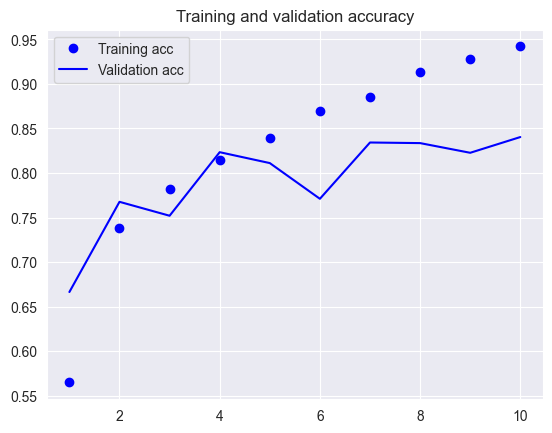

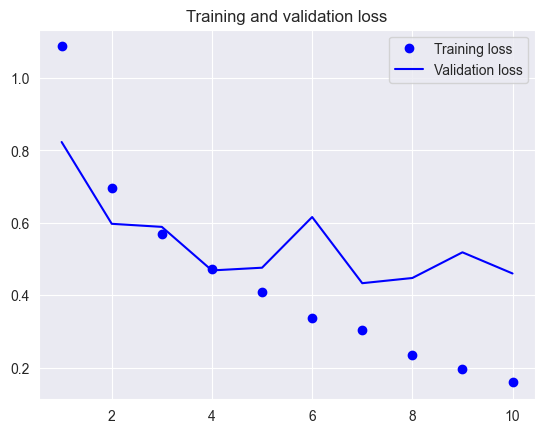

In [132]:
plot_acc_loss(base_history)

In general the base model achieve an accuracy of 0.94%. Based in the plot off accuracies and losses the model shows an absolutely justifiable perfomance. Nevertheless the model starts showing typicall signs of overfitting from epoch 5-6 onwards. The trainings accuracy is increasing and the validation accuracy is not following and stagnates a around 83% accuracy. The same pattern can be observed for the training and validation loss. The trainings loss is decreasing for each epoch. Whereas the validation loss increases from the 6th epoch onwards.

In the next step I will evaluate the model using the test data. To do this, the model will need to classify unseen images. Based on the predictions and the actual values, the performance of the model can be assessed more accurately.

22/22 [==============================] - 2s 101ms/step


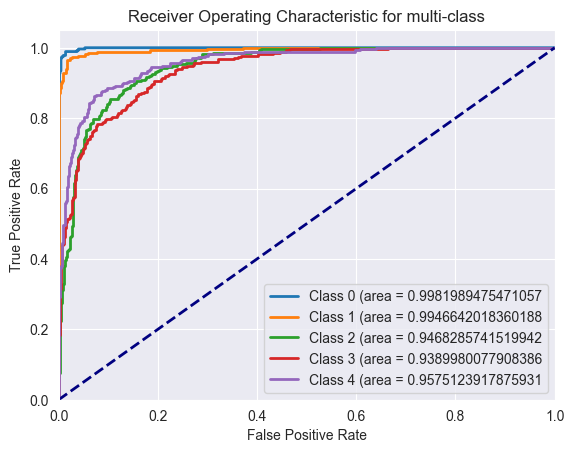

Overall ROC AUC: 0.9672404246227101


In [133]:
# predicting unseen data and printing the ROCH => See helper functions for details of method plot_roc_auc
plot_roc_auc(base_model, test_generator)

The Receiver Operating Characteritsic (ROC) graph shows the models performance for classifying each class. Overall all the individual classes show high AUC values with minor differences between the single classes. That means the model has a high true positiv rate (TPR). The overall AUC ROC value with roughly 96% represents an aggregate measure of all the classes. The high value indicates a high discrimination capability for the model between the target classes. In addition to the high values, it can also be seen that the TOR for classes 3, 4 and 5 are lower. This means that the model can, for example, distinguish between classes 1 and 2 (cat and dog) very well. The model performs worse in the other classes. The model performs worst, especially in class 3, the Elephant class.

A confusion matrix could provide more insights here. Additionaly the values for Accuracy, Precision and Recall are printed to give more detailes insights for the classes.



21/21 [==============================] - 2s 95ms/step


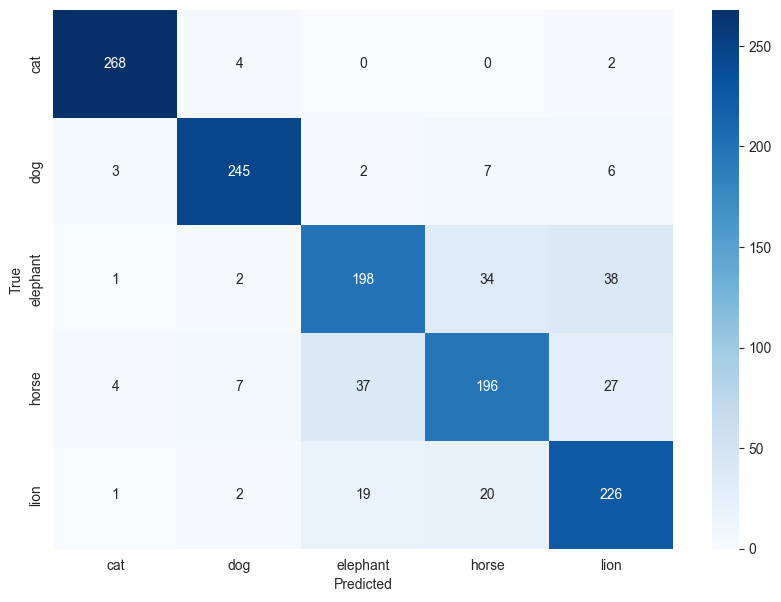

              precision    recall  f1-score   support

         cat       0.97      0.98      0.97       274
         dog       0.94      0.93      0.94       263
    elephant       0.77      0.73      0.75       273
       horse       0.76      0.72      0.74       271
        lion       0.76      0.84      0.80       268

    accuracy                           0.84      1349
   macro avg       0.84      0.84      0.84      1349
weighted avg       0.84      0.84      0.84      1349


In [134]:
plot_conf_matrix(base_model, test_generator)

Observations in the confusion matrix:

- Cats and Dogs (class 0 and 1): The model perform exceptional well on cats and dogs. There high number of true positives and a low number of misclassifications
- Elephants (class 2): The model struggles to classify elephants correctly. Elephants were misclassified as horses or lions
- Horses (class 3): There also notable misclassifications for horses 
- Lions (class 4): Lions are sometimes misclassified as horses or elephants, but still have a high true positiv count

It seems to be that the model has difficulties to distinguish between horses and elephants.

Observations Classification Report:

- Cats and Dogs: High precision and recall, indicating very view misclassifications
- Elephnats: This class has the lowest precision and a low recall, showing that not all elephants have been correctly classified as elephants and that they were more often misclassified as other animals (especially horeses and lions)
- Horses: The precision and recall shows also relatively low values

Still the overall accuracy of the base model is still high, even if this metric is not reflecting the class specific performance. The wighted average and the macro average showing the same values which is an indicator, that the dataset is well balanced for all 5 classes.

To improve the models performance, especially the ability to better discrimate between classes like horses and elephant, following steps will be applied:
- reduce complexity of model architecture
- add drop-out layers to improve generalization
- reduce the number of filters for the Conv2D-layers
- add regualizers


For the next step the achritecture of the model is simplidied. It has less Conv2D layers, viewer filters and reduced number of neurons for the dense layer.

In [145]:
# intializing simpler  model
simple_model= models.Sequential()
simple_model.add(layers.Conv2D(8, (3,3), activation='relu', input_shape= input_shape))
simple_model.add(layers.MaxPooling2D((2,2)))
simple_model.add(layers.Conv2D(16, (3,3), activation= 'relu'))
simple_model.add(layers.MaxPooling2D((2,2)))
simple_model.add(layers.Flatten())
simple_model.add(layers.Dense(20, activation='relu'))
simple_model.add(layers.Dense(5, activation='softmax'))

In [146]:
simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [147]:
simple_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 8)       224       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 74, 74, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 16)        1168      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 36, 36, 16)        0         
 ng2D)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 20736)             0         
                                                                 
 dense_24 (Dense)            (None, 20)              

In [148]:
simple_history= simple_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs= 10,
    validation_data= val_generator,
    validation_steps= validation_steps
)

Epoch 1/10
170/170 [==============================] - 22s 127ms/step - loss: 1.4104 - accuracy: 0.3907 - val_loss: 1.3396 - val_accuracy: 0.4789
Epoch 2/10
170/170 [==============================] - 21s 126ms/step - loss: 1.1374 - accuracy: 0.5469 - val_loss: 1.0886 - val_accuracy: 0.5530
Epoch 3/10
170/170 [==============================] - 21s 126ms/step - loss: 0.9644 - accuracy: 0.6291 - val_loss: 0.9015 - val_accuracy: 0.6529
Epoch 4/10
170/170 [==============================] - 22s 128ms/step - loss: 0.8200 - accuracy: 0.6845 - val_loss: 0.8007 - val_accuracy: 0.6923
Epoch 5/10
170/170 [==============================] - 22s 127ms/step - loss: 0.7320 - accuracy: 0.7167 - val_loss: 0.8646 - val_accuracy: 0.6522
Epoch 6/10
170/170 [==============================] - 22s 128ms/step - loss: 0.6516 - accuracy: 0.7477 - val_loss: 0.7190 - val_accuracy: 0.7255
Epoch 7/10
170/170 [==============================] - 22s 129ms/step - loss: 0.5860 - accuracy: 0.7751 - val_loss: 0.6906 - val_ac

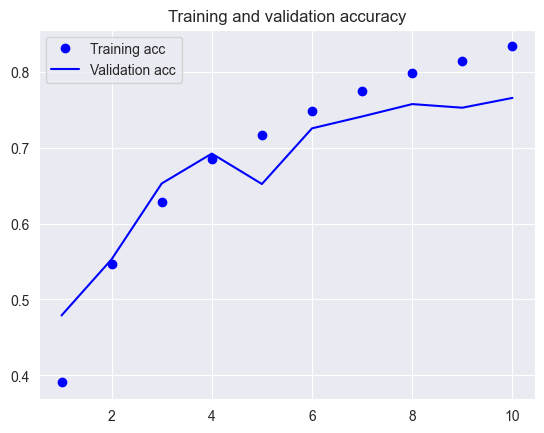

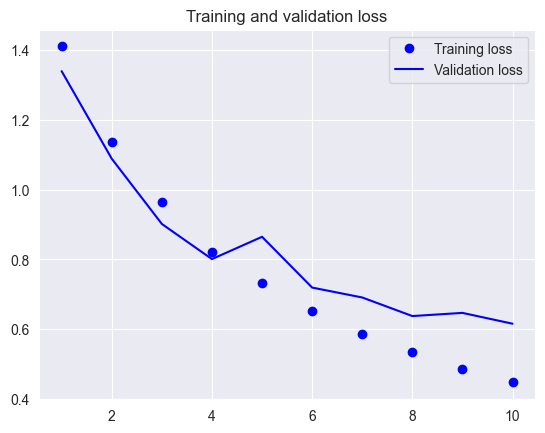

In [149]:
plot_acc_loss(simple_history)

The trainings accuracy of the model is high, meaning that the model can  adapt to the training data very well. The accuracy of the validation data compared to the training data is relatively low, though. This behavior indicates that the model is not good at generalizing on unseen data, which is a sign of overfitting. Also this behavior can be observed for the corresponding loss curve. The validation loss is not following the trainings loss downwards. 

22/22 [==============================] - 2s 94ms/step


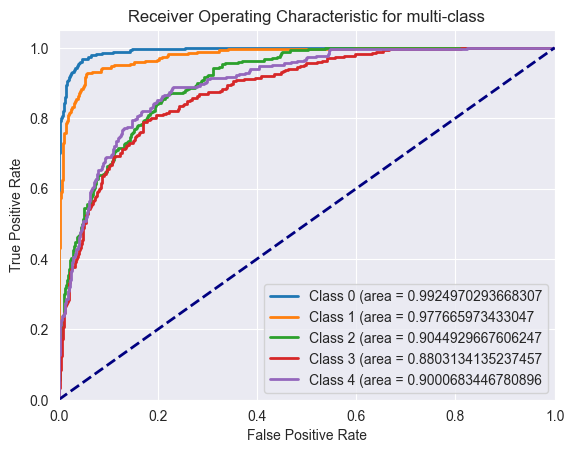

Overall ROC AUC: 0.9310075455524676


In [150]:
plot_roc_auc(simple_model, test_generator)

The ROC graphs shows a extraordinary performance for classifying cats and dogs. However, a clear deterioration can be seen in the elephant, horse and lion classes. This is also clear in the overall ROC AUC value, which has worsened by 2 percentage points compared to the previous model.

21/21 [==============================] - 2s 84ms/step


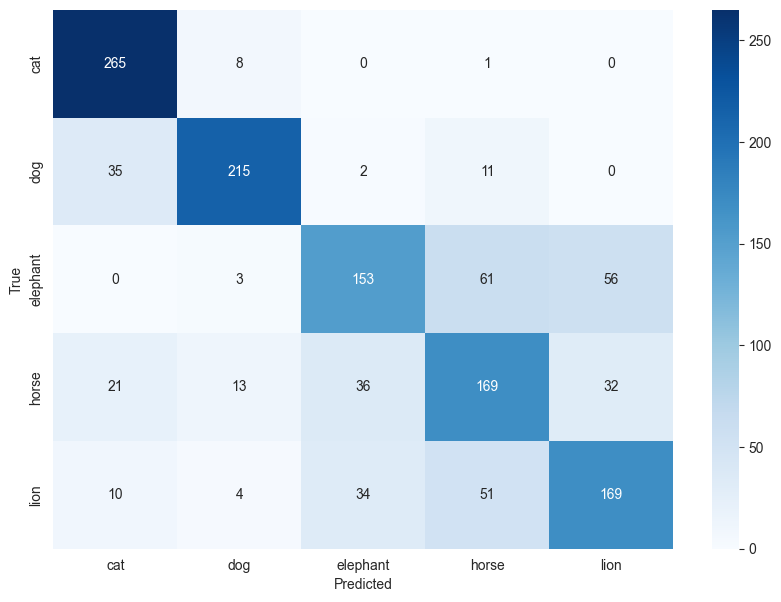

              precision    recall  f1-score   support

         cat       0.80      0.97      0.88       274
         dog       0.88      0.82      0.85       263
    elephant       0.68      0.56      0.61       273
       horse       0.58      0.62      0.60       271
        lion       0.66      0.63      0.64       268

    accuracy                           0.72      1349
   macro avg       0.72      0.72      0.72      1349
weighted avg       0.72      0.72      0.72      1349


In [151]:
plot_conf_matrix(simple_model, test_generator)

A deteriorated line is also clear in the confusion matrix. Here too, the correct classification of the classes elephant, horse and lion was much worse. The elephant and horse classes were most often incorrectly differentiated. This suggests that the model with the reduced architecture is unable to recognize the complex differences between elephants and horses.

This is also reflected in the classification report. The weighted average also catches the eye. This is 6 percent points worse than the basic model.

In order to improve the performance of the model, in the next steps I will increase the complexity of the architecture again, use data augmentation, as well as dropout layers and regularizers.

# Applying Measures to Improve Model Performance

In this section outlines the implementation of various techniques to enhance the model's generalization capabilities and robustness. Specifically, data augmentation, regularization techniques, dropout layers, and early stopping mechanisms are employed.

Over the course of this section two models will be explored with nuanced differences in their architecture and evaluate their performance:

- **Initialize Data Augmentation**: Increase diversity of training data, improving models ability to generalize


- **Model 1 Implementation**: 
    - **Architecture**: Dropout layers and l2 kernel regularizers
    - **Evaluation**: Analyze model's performance using accuracy and loss graphs, ROC curves, confusion matrices and classification report

- **Model 2 Implementation**: 
    - **Architecture**: Dropout layers and l2 kernel regularizers and early stopping
    - **Evaluation**: Analyze model's performance using accuracy and loss graphs, ROC curves, confusion matrices and classification report


## Applying Data Augmentation

In [152]:
# Initializes an ImageDataGenerator for training data
train_aug_img_data_gen= ImageDataGenerator(
    rescale= 1./255,  # Rescales the image values so that each pixel value is within 0. and 1.
    rotation_range=40,  # Randomly rotates the images within a range of -40 to +40 degrees
    width_shift_range=0.2,  # Randomly translates the images horizontally by a factor of the image width 20%
    height_shift_range= 0.2,  # Randomly translates the images vertically by a factor of the image height 20%
    shear_range=0.2,  # Randomly applies shearing transformations within a range of -20% to +20%
    zoom_range= 0.2,  # Randomly zooms inside the pictures by a factor of 20%
    horizontal_flip= True,  # Randomly flips the images horizontally (mirror image)
    fill_mode='nearest'  # Specifies the strategy to fill in new pixels that can appear after a rotation or a width/height shift
)


The code cell presented above implements the technique of data augmentation. Data augmentation is employed as a strategy to mitigate the risk of overfitting by increasing both the quantity and variability of the training data, thereby supporting the model's capacity for better generalization. Through the introduction of variations in the image data, the model is encouraged not to depend excessively on specific attributes of the training dataset.

In [153]:
# Initialite an ImageDataGenerator for validation data
val_aug_img_data_gen= ImageDataGenerator(
    rescale= 1./255,    # Rescales the image values so that each pixel value is within 0. and 1.
)

In [215]:
train_aug_generator= train_aug_img_data_gen.flow_from_directory(
    dir_base_train,  # Path to the target directory
    target_size=(150,150),  # The dimensions to which all images found will be resized -> 150x150 pixels
    batch_size=64,  # The size of the batches of images to yield
    class_mode='categorical',  # Type of label arrays that are returned --> 'categorical': 2D one-hot encoded labels
    shuffle= True,  # Shuffle the data --> the model does not see images in the same order during each epoch
)


Found 12125 images belonging to 5 classes.


In [216]:
val_aug_generator= val_aug_img_data_gen.flow_from_directory(
    dir_base_val,   # Path to the target directory
    target_size=(150,150),  # # The dimensions to which all images found will be resized -> 150x150 pixels
    batch_size=64,  # The size of the batches of images to yield
    class_mode='categorical',   # Type of label arrays that are returned --> 'categorical': 2D one-hot encoded labels
    shuffle= True  # Shuffle the data --> the model does not see images in the same order during each epoch
)

Found 1497 images belonging to 5 classes.


The follwings cell code prints a augmented pictures to visualize the results of data augmentation for one picture.

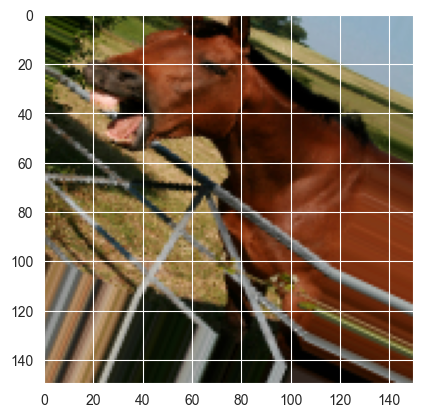

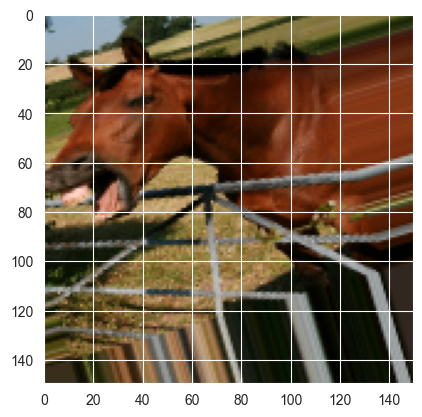

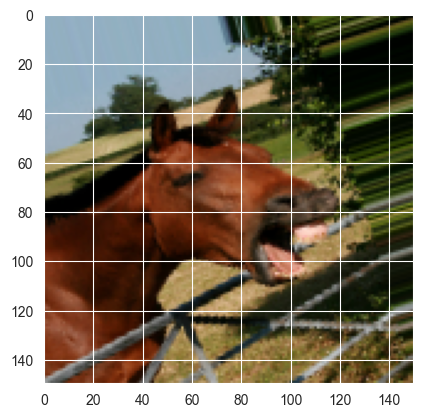

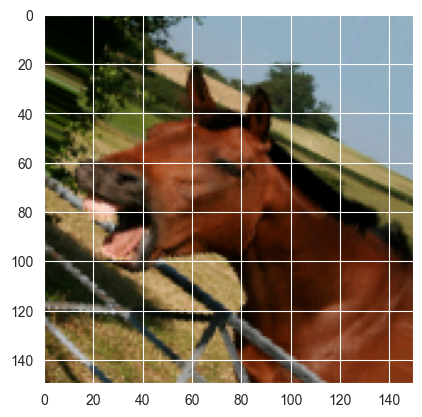

In [217]:
# displaying some random pics
from keras.preprocessing import image

# Generate a list of filenames
fnames= [os.path.join('./data/animals/train/horse', fname) for fname in os.listdir('./data/animals/train/horse')]

# Select a specific image path 
img_path= fnames[8]

# Load the selected image  and resize it to 150x150 pixels
img= image.load_img(img_path, target_size=(150,150))

# Image is converted to a 3D array (height, width, channels)
# Following, it's reshaped to (1, height, width, channels) to fit the model's expected input
x= image.img_to_array(img)
x= x.reshape((1,) + x.shape)

# Initialize a counter to track the number of images generated
i=0

# Use the data generator to augment the selected image
# For each batch (in this case, containing just 1 image) generated by the data augmentation:
for batch in train_aug_img_data_gen.flow(x, batch_size=1):
    plt.figure(i)  # Create a new figure for plotting
    imgplot= plt.imshow(image.array_to_img(batch[0]))  # Convert the first image in the batch from a numpy array back into a PIL image and display it
    i += 1  # Increment the counter.
    if i % 4 == 0:  # If four images have been generated, exit the loop
        break
    
plt.show()  # Display all the figures with the augmented images

## Model 1 Implementaion

In [157]:
# Import regularizers from TensorFlow Keras for applying regularization to the model.
from tensorflow.keras import regularizers


model_da= models.Sequential()   # Initialize a sequential model

model_da.add(layers.Conv2D(32, (3,3), activation='relu', input_shape= input_shape, kernel_regularizer=regularizers.l2(1e-5)))   # Add a convolutional layer with L2 regularization
model_da.add(layers.MaxPooling2D((2,2)))    # Add a max pooling layer
model_da.add(layers.Dropout(0.5))   # Add a dropout layer
model_da.add(layers.Conv2D(64, (3,3), activation= 'relu', kernel_regularizer=regularizers.l2(1e-5)))    # Add Conv2D layer with L2 regularization
model_da.add(layers.MaxPooling2D((2,2))) # Add a max pooling layer
model_da.add(layers.Dropout(0.5))   # Add a dropout layer
model_da.add(layers.Flatten())  # Add a flatten layer to convert the 2D outputs into a 1D tensor
model_da.add(layers.Dropout(0.5))   # Add a dropout layer
model_da.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5)))     # Add a dense layer applying L2 regularization.
model_da.add(layers.Dense(5, activation='softmax')) # This layer outputs the probability distribution over the 5 classes


The model depicted above adheres to the traditional architecture of a CNN, as previously outlined. Beyond the foundational architecture, this model incorporates Dropout layers and regularization techniques to improve performance and generalization.

Dropout layers serve as a regularization mechanism by temporarily excluding neurons, along with their inbound and outbound connections, from the network during the training phase. As batches of images are processed, each neuron has a 50% chance of being temporarily omitted. This strategy is designed to compel the network to learn more robust and generalizable features by relying on a diverse array of neuron subsets.

Kernel regularizers are employed to impose penalties on the parameters of layers during optimization processes. These penalties are integrated into the loss function, which the network aims to minimize. Specifically, the L2 regularizer is utilized to facilitate weight decay, encouraging the model's weights to remain small yet non-zero. This regularization technique assists the model in avoiding overly precise adjustments to the training data, promoting better generalization to new, unseen data.

In [158]:
# Compile the model
model_da.compile(
    optimizer='adam',  # Use the Adam optimization algorithm
    loss='categorical_crossentropy',  # Use categorical crossentropy suitable for multi-class classification 
    metrics=['accuracy']  # Evaluate the model based on accuracy during training and testing
)

In [159]:
steps_per_epoch= np.ceil(train_aug_generator.samples / train_aug_generator.batch_size)  # Calculate steps per epoch based on sample size divided by batch size
validation_steps= np.ceil(val_aug_generator.samples / val_aug_generator.batch_size) # Calculate validation steps per epoch based on sample size divided by batch size

In [160]:
# Train the model using augmented training data 
history_da= model_da.fit(
    train_aug_generator,    # Set Training generator as input yielding batches of training data
    steps_per_epoch=steps_per_epoch,    # Set steps per epoch
    epochs= 50, # define number of epochs
    validation_data= val_aug_generator, # Set validation generator as input that yields batches of validation data
    validation_steps= validation_steps  # Set number of validation steps
)

Epoch 1/50
190/190 [==============================] - 52s 273ms/step - loss: 1.5595 - accuracy: 0.3287 - val_loss: 1.4021 - val_accuracy: 0.4068
Epoch 2/50
190/190 [==============================] - 52s 274ms/step - loss: 1.3564 - accuracy: 0.4437 - val_loss: 1.1480 - val_accuracy: 0.5872
Epoch 3/50
190/190 [==============================] - 52s 272ms/step - loss: 1.2250 - accuracy: 0.5148 - val_loss: 0.9604 - val_accuracy: 0.6573
Epoch 4/50
190/190 [==============================] - 52s 272ms/step - loss: 1.1317 - accuracy: 0.5507 - val_loss: 0.9090 - val_accuracy: 0.6667
Epoch 5/50
190/190 [==============================] - 52s 274ms/step - loss: 1.0795 - accuracy: 0.5817 - val_loss: 0.8488 - val_accuracy: 0.6767
Epoch 6/50
190/190 [==============================] - 52s 274ms/step - loss: 1.0439 - accuracy: 0.5963 - val_loss: 0.8206 - val_accuracy: 0.7174
Epoch 7/50
190/190 [==============================] - 52s 273ms/step - loss: 1.0027 - accuracy: 0.6095 - val_loss: 0.7843 - val_ac

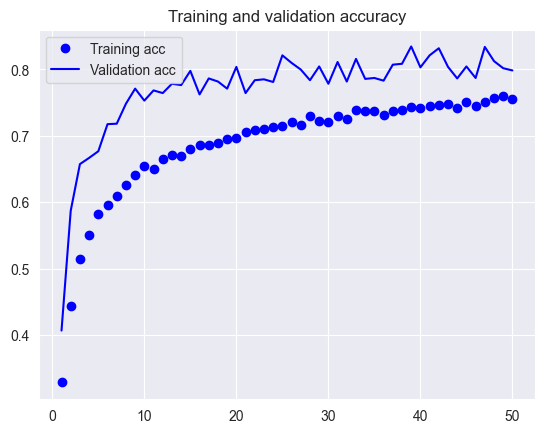

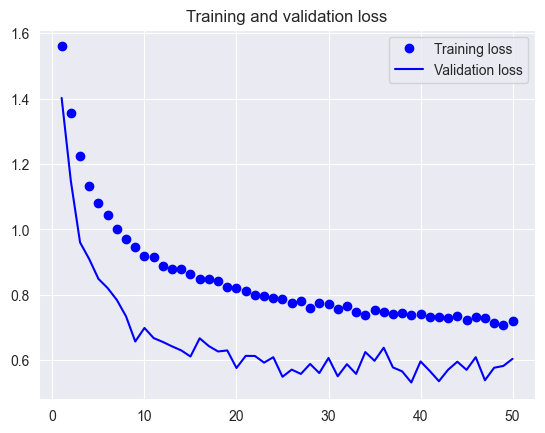

In [161]:
plot_acc_loss(history_da)   # plot acc & loss 

The model reached a validation accuracy of 79%. This is a deterioration of almost 6% compared to the base model. However, the model was trained significantly longer (50 epochs) than the base model (10 epochs) without showing any signs of overfitting. With this diagram it is also important to note that accuracy only provides a superficial insight into the performance of the model. Therefore, it makes sense to take a closer look at the ROC curve.

22/22 [==============================] - 2s 101ms/step


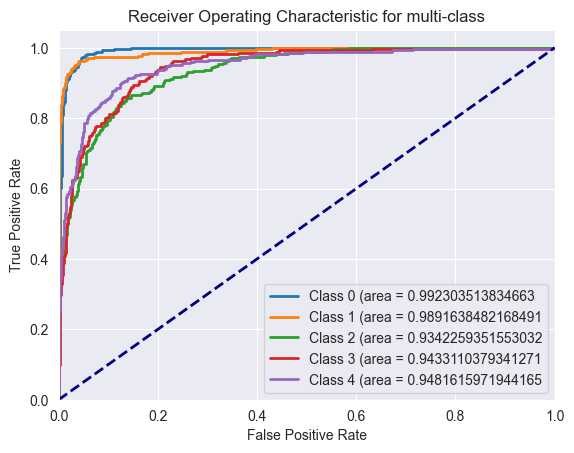

Overall ROC AUC: 0.9614331864670718


In [162]:
plot_roc_auc(model_da, test_generator)

Having a closer look at the ROC curve it can be observed almost all line in the top left corner which is indicating an excellent model performance. This is supported by the high value of the AUCs. The model performs consistently across different classes with an AUC for each class over 0.93 . Next, we will direct our attention towards a thorough evaluation of the confusion matrix and classification report.

21/21 [==============================] - 2s 99ms/step


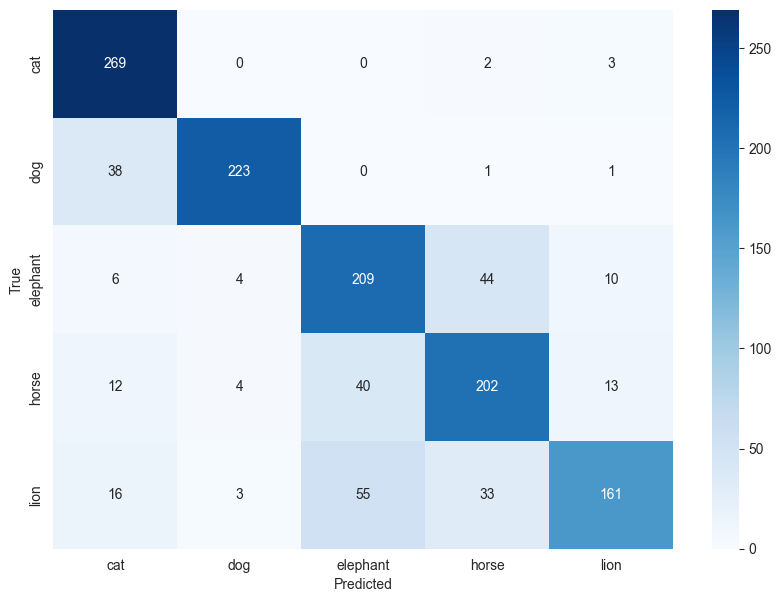

              precision    recall  f1-score   support

         cat       0.79      0.98      0.87       274
         dog       0.95      0.85      0.90       263
    elephant       0.69      0.77      0.72       273
       horse       0.72      0.75      0.73       271
        lion       0.86      0.60      0.71       268

    accuracy                           0.79      1349
   macro avg       0.80      0.79      0.79      1349
weighted avg       0.80      0.79      0.79      1349


In [163]:
plot_conf_matrix(model_da, test_generator)

**Confusion Matrix:**
The diagonal values (true positives - TP) indicating the correct classifications. Especially the classes cats and dogs have a high TP rate. The 'horse' class shows a noteable number of misclassifications with 'elephant'. Similary, 'lion' is often misclassified as 'elephant'. It would be interesting to further investigate of e.g. the background of 'lion' and 'elephant' has biased the model. Hence 'lion' and 'elephant' most probably could be experienced in the same environmental context.

**Classification Report:**
The classification report shows that the class 'dogs' reached the highest precision which shows that 95% of the time predicting a dog it was truly a dog. The class 'cat' shows the highest recall of 98%, meaning that it correctly identified 98% of all the cats. Overall the model is performing reasonably well.

In comparison to the base model there were some minor shifts for the values for classes 'cats' and 'dogs'. The improved model has demonstrated better balance and effectiveness  across all classes. That improvements in the actual model show that the changes that were made had a positive impact on the models ability to generalize across different classes. 

## Model 2 Implementation

In [218]:
# Import Early Stopping from Keras' callbacks
from tensorflow.keras.callbacks import EarlyStopping

# Initialize EarlyStopping callback to monitor models validation loss
early_stopping = EarlyStopping(
    monitor= 'val_loss',    # Define the metric to monitor -> In this case validation loss is monitored
    patience=5, # Number of epochs without improvement after the training will be stopped
    verbose= 1, # Verbosity 1 -> will print a message each time the call back takes action
    restore_best_weights= True  # Model weights will be reverted to state wgeb validation loss was at its minimum
) 

The code shown above intialize the early stopping callback. The early sopping is handed over to the model when calling the models 'fit' method. During the training the early stopping monitors the validation loss. If the validation loss remains almost the same over a course of 5 epochs the call back will terminate the training process. Finally, it restores the weights corresponding to the best achieved metric. 

In [197]:
from tensorflow.keras import regularizers

# intializing model -> model_da_es is abreviation for 'model data augmentation (da) and early stopping (es) 
model_da_es= models.Sequential()
model_da_es.add(layers.Conv2D(32, (3,3), activation='relu', input_shape= input_shape, kernel_regularizer=regularizers.l2(1e-5)))
model_da_es.add(layers.MaxPooling2D((2,2)))
model_da_es.add(layers.Dropout(0.5))
model_da_es.add(layers.Conv2D(64, (3,3), activation= 'relu', kernel_regularizer=regularizers.l2(1e-5)))
model_da_es.add(layers.MaxPooling2D((2,2)))
model_da_es.add(layers.Dropout(0.5))
model_da_es.add(layers.Flatten())
model_da_es.add(layers.Dropout(0.5))
model_da_es.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-5))) # Increased number of neurons from 64 to 128
model_da_es.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-5))) # Added additional dense layer to be able to better discrimnate between elphants and horse
model_da_es.add(layers.Dense(5, activation='softmax')) 

The model in the top cell is very similar in structure to model 1, with the exception that an additional dense layer was added and that the number of neurons in both dense layers was set to 128. The more complex model structure is intended to make it possible to better distinguish between the individual classes, such as 'elephant' and 'horse'.

In [219]:
# Compile model 2
model_da_es.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
) 

In [199]:
# defining the steps per epoch and validation steps
steps_per_epoch= np.ceil(train_aug_generator.samples / train_aug_generator.batch_size)
validation_steps= np.ceil(val_aug_generator.samples / val_aug_generator.batch_size)

In [200]:
history_da_es= model_da_es.fit(
    train_aug_generator,
    steps_per_epoch=steps_per_epoch,
    epochs= 100,    # For this model the epochs were significantly increased, so the early stopping can work and stop the model when no progress is achieved
    validation_data= val_aug_generator,
    validation_steps= validation_steps,
    callbacks= [early_stopping]
)

Epoch 1/100
190/190 [==============================] - 53s 276ms/step - loss: 1.6120 - accuracy: 0.2904 - val_loss: 1.4866 - val_accuracy: 0.3674
Epoch 2/100
190/190 [==============================] - 53s 276ms/step - loss: 1.3749 - accuracy: 0.4228 - val_loss: 1.1535 - val_accuracy: 0.5651
Epoch 3/100
190/190 [==============================] - 53s 278ms/step - loss: 1.1953 - accuracy: 0.5142 - val_loss: 0.9219 - val_accuracy: 0.6359
Epoch 4/100
190/190 [==============================] - 53s 277ms/step - loss: 1.1196 - accuracy: 0.5573 - val_loss: 0.8947 - val_accuracy: 0.6834
Epoch 5/100
190/190 [==============================] - 53s 278ms/step - loss: 1.0601 - accuracy: 0.5815 - val_loss: 0.7907 - val_accuracy: 0.7214
Epoch 6/100
190/190 [==============================] - 53s 277ms/step - loss: 1.0243 - accuracy: 0.6002 - val_loss: 0.8649 - val_accuracy: 0.6640
Epoch 7/100
190/190 [==============================] - 53s 278ms/step - loss: 0.9785 - accuracy: 0.6240 - val_loss: 0.7411 -

When analyzing the course of the individual training epochs, it can be seen that at epoch 30 the 'early stopping' mechanism stopped the training and the best model weights were restored.

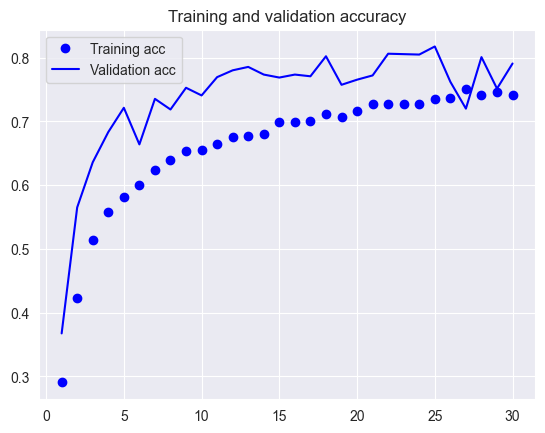

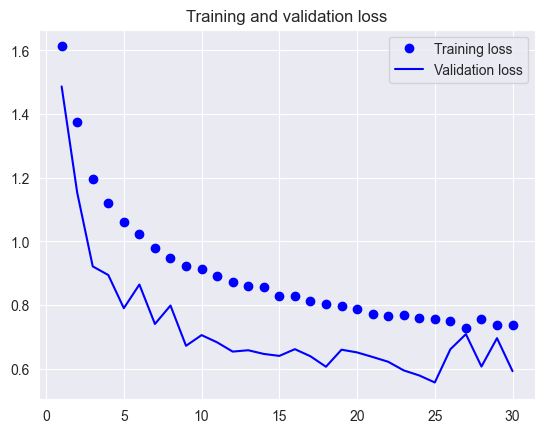

In [220]:
plot_acc_loss(history_da_es)

**Training and Validation Accuracy Chart:**

The training accuracy increases consistently, showing good learning on the training set.
The validation accuracy plateaus and shows variability towards the later epochs, suggesting the model isn't improving on the validation set after a certain point.
Early stopping kicked in at epoch 30, which likely prevented further overfitting.

**Training and Validation Loss Chart:**

The training loss decreases, indicating learning progress. It's normal for training loss to reduce as the model's fit to the training data improves.
The validation loss decreases but shows signs of instability in the later epochs. This variance is a common trigger for early stopping to prevent overfitting.
Since the early stopping callback ceased training at epoch 30, it likely did so in response to the validation loss not improving for a number of epochs set in the patience parameter.

22/22 [==============================] - 2s 101ms/step


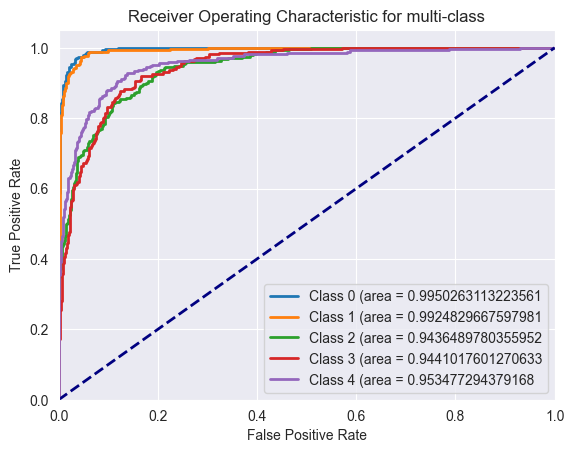

Overall ROC AUC: 0.965747462124796


In [221]:
plot_roc_auc(model_da_es, test_generator)

The ROC curves in the left top corner for each class, indicating a high true positive rate. The AUC (area under the curve) for each class is very high, ranging from 94% to 99%. This suggests an excellent discriminative ability for each class.

The overall ROC AUC of 96% is indicating an overall high ability to distinguish between the classes. The model performs consistently well over all classes, which is an evidence for high performance.

21/21 [==============================] - 2s 109ms/step


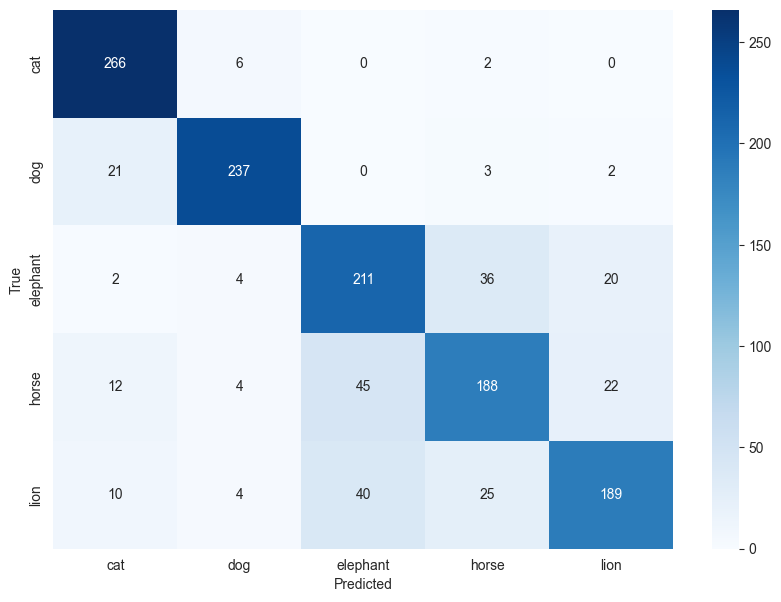

              precision    recall  f1-score   support

         cat       0.86      0.97      0.91       274
         dog       0.93      0.90      0.92       263
    elephant       0.71      0.77      0.74       273
       horse       0.74      0.69      0.72       271
        lion       0.81      0.71      0.75       268

    accuracy                           0.81      1349
   macro avg       0.81      0.81      0.81      1349
weighted avg       0.81      0.81      0.81      1349


In [222]:
plot_conf_matrix(model_da_es, test_generator)

**Confusion Matrix:**
The confusion matrix shows high number of True positives for class 'cat' and 'dog'. The model is still struggling classifying correctly 'horse' and 'elephants'. Compared to the previous matrix the values got worse.

**Classification Report:**
The precision for 'cat', 'elephant' and 'horse' has improved. The recall for 'dog' was improved significantly and F1-Score was improved for all classes except the class 'horse'.

The overall performance of the model has improved. This can be seen by the increase of the overall accuracy (macro and weighted). The same for the values for precision decreased for two classes ('dog' and 'lion') slightly, but have been improved overall. This observation can be done for the F1-Score as well.
In conclusion, the model has shown improvement in classifying the given classes, but there is still room for an upgrade. 

In [223]:
# save the model
model_da_es.save('animals.keras')

# Using a pretrained convolutional Model

In this section the pretrained model VGG16 will be used to classify the 'Animals' dataset. The pretrained model will be freezed and the dense layers on top of it are trained to perform the classifications.


In [228]:
# Import the pretrained model VGG16
from keras.applications import VGG16

In [229]:
# Load the VGG16 model pre-trained weights on ImageNet dataset as a convolutional base
conv_base= VGG16(
    weights='imagenet', # Use weights pre-trained on ImageNet
    include_top=False,  # Do not include the fully-connected layer at the top of the network
    input_shape=(150, 150, 3)   # Define the input shape of the images that will be fed to the network
)

In [230]:
# show summary of the conv_base model
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [231]:
# Initialize a sequential model to stack layers on top of each other
model_cbase_aug= models.Sequential()
model_cbase_aug.add(conv_base)  # Add the pre-trained VGG16 base (without its top layers) to the model
model_cbase_aug.add(layers.Flatten())   # Flatten the output of the conv_base to a 1D vector to feed into the dense layers
model_cbase_aug.add(layers.Dense(128, activation='relu'))   # Add a dense layer with 128 neurons and ReLU activation
model_cbase_aug.add(layers.Dense(5, activation='softmax'))  # Add a dense layer with 5 neurons and ReLU activation to predict target classes



In [232]:
model_cbase_aug.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_21 (Flatten)        (None, 8192)              0         
                                                                 
 dense_45 (Dense)            (None, 128)               1048704   
                                                                 
 dense_46 (Dense)            (None, 5)                 645       
                                                                 
Total params: 15764037 (60.14 MB)
Trainable params: 15764037 (60.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [233]:
print(f'Number of trainable wieghts: {len(model_cbase_aug.trainable_weights)}')

Number of trainable wieghts: 30


In [234]:
# Freeze the convultional base that the weights of the model cannot be adapted throughout the trainings process
conv_base.trainable = False

In [236]:
# Check if weights for models have been disabled
print(f'Number of trainable weights after freezing model base: {len(model_cbase_aug.trainable_weights)}')

Number of trainable weights after freezing model base: 4


In [212]:
# Calculate number of steps per epoch for training and validation
steps_per_epoch= train_aug_generator.samples // train_aug_generator.batch_size
validation_steps= val_generator.samples // val_generator.batch_size

In [237]:
# compile the model and set corresponding parameters for optimizer, loss function and define metric
model_cbase_aug.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy']
)

In [239]:
history_model_cbase_aug = model_cbase_aug.fit(
    train_aug_generator,
    steps_per_epoch= steps_per_epoch,
    epochs= 10,
    validation_data= val_generator,
    validation_steps= validation_steps
)

Epoch 1/10
189/189 [==============================] - 280s 1s/step - loss: 0.6040 - accuracy: 0.7667 - val_loss: 0.3307 - val_accuracy: 0.8614
Epoch 2/10
189/189 [==============================] - 280s 1s/step - loss: 0.4178 - accuracy: 0.8360 - val_loss: 0.2617 - val_accuracy: 0.8974
Epoch 3/10
189/189 [==============================] - 280s 1s/step - loss: 0.3871 - accuracy: 0.8472 - val_loss: 0.2584 - val_accuracy: 0.8981
Epoch 4/10
189/189 [==============================] - 280s 1s/step - loss: 0.3777 - accuracy: 0.8530 - val_loss: 0.2393 - val_accuracy: 0.9103
Epoch 5/10
189/189 [==============================] - 282s 1s/step - loss: 0.3635 - accuracy: 0.8582 - val_loss: 0.2505 - val_accuracy: 0.8981
Epoch 6/10
189/189 [==============================] - 286s 2s/step - loss: 0.3546 - accuracy: 0.8599 - val_loss: 0.2290 - val_accuracy: 0.9096
Epoch 7/10
189/189 [==============================] - 286s 2s/step - loss: 0.3374 - accuracy: 0.8673 - val_loss: 0.2557 - val_accuracy: 0.8967

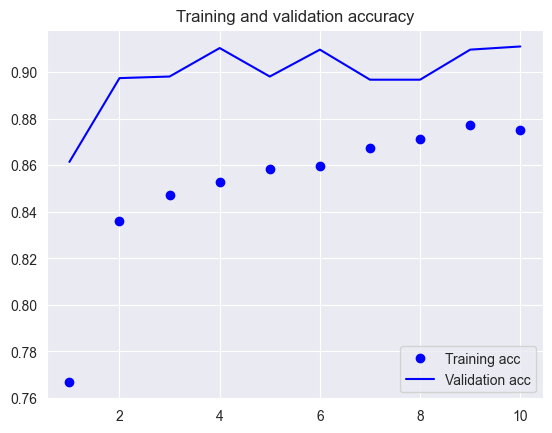

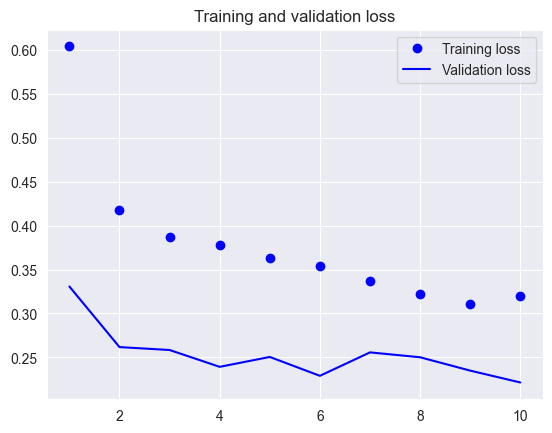

In [240]:
plot_acc_loss(history_model_cbase_aug)

**Training and Validation Accuracy Chart:**

The training accuracy starts high and remains stable throughout training, indicating that the model is consistently good at classifying the training data.
The validation accuracy is slightly higher than the training accuracy, this could occur when the model uses dropout layers during training. When the during the validation the whole capacity of the network is used. This could lead to a higher validation accuracy and a corresponding lower validation loss.


**Training and Validation Loss Chart:**

The training loss decreases initially and then stabilizes, which is expected behavior as the model learns from the training data.
The validation loss is relatively low and stable throughout the epochs, with some minor fluctuations. It does not exhibit a clear upward trend, suggesting that the model is not overfitting the training data. A similar phenomenon ( validation loss lower than trainings loss) can be observed.

The model is performing well, with a stable loss and accuracy over the epochs. There could be some improvements through fine-tuning for loss and accuracy.

22/22 [==============================] - 28s 1s/step


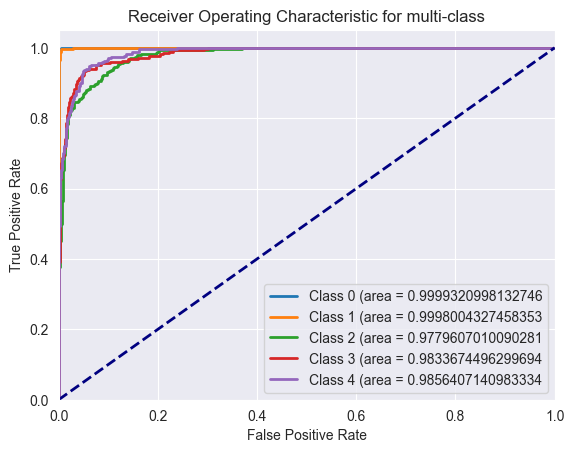

Overall ROC AUC: 0.9893402794592883


In [241]:
plot_roc_auc(model_cbase_aug, test_generator)

The lines for classes 0 and 1 are shown in the upper left corner, almost at a right angle. This indicates the very high accuracy of the model. The curves of the other classes have also improved significantly compared to the previous model ( model 2).

The overall ROC AUC of 98% is indicating an excellent high ability to discriminate between the classes. The model performs consistently well for all classes.

21/21 [==============================] - 28s 1s/step


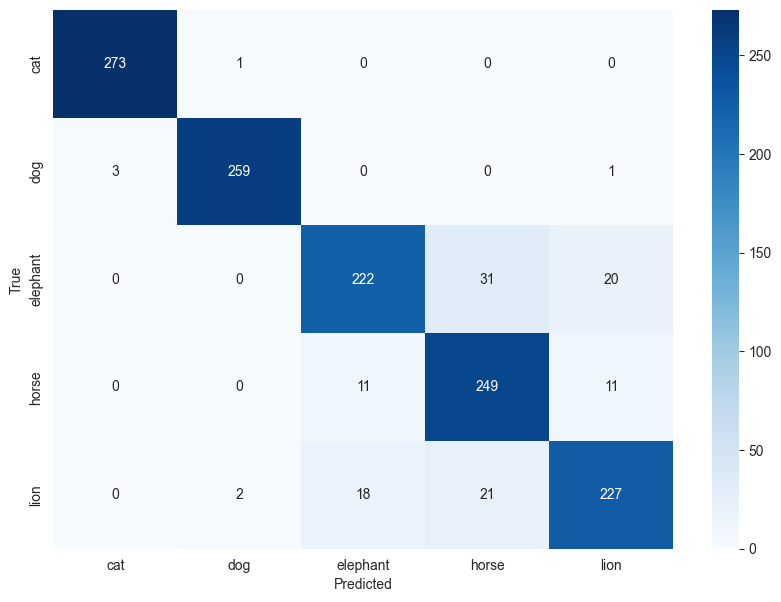

              precision    recall  f1-score   support

         cat       0.99      1.00      0.99       274
         dog       0.99      0.98      0.99       263
    elephant       0.88      0.81      0.85       273
       horse       0.83      0.92      0.87       271
        lion       0.88      0.85      0.86       268

    accuracy                           0.91      1349
   macro avg       0.91      0.91      0.91      1349
weighted avg       0.91      0.91      0.91      1349


In [242]:
plot_conf_matrix(model_cbase_aug, test_generator)

# References:

[1] Kaggle - Animals: Animals Classification Dataset; Url: https://www.kaggle.com/datasets/antobenedetti/animals/